In [ ]:
import gzip
import os
import numpy as np
from six.moves import urllib
from six.moves import xrange
import torch
import torchvision
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
import time
from google.colab import drive
from google.colab import files
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


code found at: https://gist.github.com/haje01/14b0e5d8bd5428df781e 

this code is from an older tensorflow mnist example. The authors of this dataset created their dataset to work with this dataloader.

I hade to do a small change in _read32 to get it to work and rename numpy to np

In [ ]:
def maybe_download(filename, work_directory):
  """Download the data from Yann's website, unless it's already here."""
  if not os.path.exists(work_directory):
    os.mkdir(work_directory)
  filepath = os.path.join(work_directory, filename)
  if not os.path.exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  return filepath

def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  result = np.frombuffer(bytestream.read(4), dtype=dt)
  return result[0]

def extract_images(filename):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError(
          'Invalid magic number %d in MNIST image file: %s' %
          (magic, filename))
    num_images = _read32(bytestream)
    #print(f"num_images: {num_images}")
    rows = _read32(bytestream)
    #print(f"rows: {rows}")
    cols = _read32(bytestream)
    #print(f"cols: {cols}")
    #print(f"multi: {rows * cols * num_images}")
    buf = bytestream.read(rows * cols * num_images)
    data = np.frombuffer(buf, dtype=np.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data

def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

def extract_labels(filename, one_hot=False):
  """Extract the labels into a 1D uint8 numpy array [index]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError(
          'Invalid magic number %d in MNIST label file: %s' %
          (magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = np.frombuffer(buf, dtype=np.uint8)
    if one_hot:
      return dense_to_one_hot(labels)
    return labels


class DataSet(object):
  def __init__(self, images, labels, fake_data=False):
    if fake_data:
      self._num_examples = 10000
    else:
      assert images.shape[0] == labels.shape[0], (
          "images.shape: %s labels.shape: %s" % (images.shape,
                                                 labels.shape))
      self._num_examples = images.shape[0]
      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      assert images.shape[3] == 1

      # TODO this is reshaping for 2D CNN uncomment next line for o.g. 1D CNN
      #images = images.reshape(images.shape[0],
      #                        images.shape[1] * images.shape[2])

      # Convert from [0, 255] -> [0.0, 1.0].
      images = images.astype(np.float32)
      images = np.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1.0 for _ in xrange(784)]
      fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)]
          
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]

def read_data_sets(train_dir, fake_data=False, one_hot=False):

  class DataSets(object):
    pass

  data_sets = DataSets()
  if fake_data:
    data_sets.train = DataSet([], [], fake_data=True)
    data_sets.validation = DataSet([], [], fake_data=True)
    data_sets.test = DataSet([], [], fake_data=True)
    return data_sets
  TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
  TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
  TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
  TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
  VALIDATION_SIZE = 5000
  local_file = maybe_download(TRAIN_IMAGES, train_dir)
  train_images = extract_images(local_file)
  local_file = maybe_download(TRAIN_LABELS, train_dir)
  train_labels = extract_labels(local_file, one_hot=one_hot)
  local_file = maybe_download(TEST_IMAGES, train_dir)
  test_images = extract_images(local_file)
  local_file = maybe_download(TEST_LABELS, train_dir)
  test_labels = extract_labels(local_file, one_hot=one_hot)
  validation_images = train_images[:VALIDATION_SIZE]
  validation_labels = train_labels[:VALIDATION_SIZE]
  train_images = train_images[VALIDATION_SIZE:]
  train_labels = train_labels[VALIDATION_SIZE:]
  data_sets.train = DataSet(train_images, train_labels)
  data_sets.validation = DataSet(validation_images, validation_labels)
  data_sets.test = DataSet(test_images, test_labels)
  return data_sets

Code credit: The following code for accuracy function and the CNN_2D class is derivative of the example CNN code provided by Assistant Instructor Nicholas Majeske in the ENGR-E 503 Intelligent Systems Engineering Course at Indiana University.

In [ ]:
def accuracy(Y, Yhat):
  if isinstance(Y, torch.Tensor) and isinstance(Yhat, torch.Tensor):
    return (torch.sum(Y == Yhat) / Y.shape[0]).item() * 100.0
  elif isinstance(Y, np.ndarray) and isinstance(Yhat, np.ndarray):
    return (np.sum(Y == Yhat) / Y.shape[0]) * 100.0
  else:
    raise ValueError()

In [ ]:
class CNN_2D(torch.nn.Module):
  def __init__(self, C_in, H_in, W_in, n_classes, debug=True):
    super(CNN_2D, self).__init__()
    self.debug = debug
    if self.debug:
        print("Input")
        print("C_in =", C_in)
        print("H_in =", H_in)
        print("W_in =", W_in)
    # Instantiate Layers
    #   Layer 1 conv1
    C_out, kernel_size, stride, padding, dilation = 16, [5, 5], [1, 1], [0, 0], [1, 1]
    H_out, W_out = self.conv2d_out_dim(H_in, W_in, kernel_size, stride, padding, dilation)
    self.conv1 = torch.nn.Conv2d(C_in, C_out, kernel_size, stride, padding, dilation)
    C_in, H_in, W_in = C_out, H_out, W_out
    if self.debug:
        print("After conv1")
        print("C_in =", C_in)
        print("H_in =", H_in)
        print("W_in =", W_in)
    #   Layer 1 pool1
    kernel_size, stride, padding, dilation = [2, 2], [2, 2], [0, 0], [1, 1]
    H_out, W_out = self.conv2d_out_dim(H_in, W_in, kernel_size, stride, padding, dilation)
    self.pool1 = torch.nn.MaxPool2d(kernel_size, stride, padding, dilation)
    C_in, H_in, W_in = C_out, H_out, W_out
    if self.debug:
        print("After pool1")
        print("C_in =", C_in)
        print("H_in =", H_in)
        print("W_in =", W_in)
    #   Layer 2 conv2
    C_out, kernel_size, stride, padding, dilation = 32, [5, 5], [1, 1], [0, 0], [1, 1]
    H_out, W_out = self.conv2d_out_dim(H_in, W_in, kernel_size, stride, padding, dilation)
    self.conv2 = torch.nn.Conv2d(C_in, C_out, kernel_size, stride, padding, dilation)
    C_in, H_in, W_in = C_out, H_out, W_out
    if self.debug:
        print("After conv2")
        print("C_in =", C_in)
        print("H_in =", H_in)
        print("W_in =", W_in)
    #   Layer 2 pool2
    kernel_size, stride, padding, dilation = [2, 2], [2, 2], [0, 0], [1, 1]
    H_out, W_out = self.conv2d_out_dim(H_in, W_in, kernel_size, stride, padding, dilation)
    self.pool2 = torch.nn.MaxPool2d(kernel_size, stride, padding, dilation)
    C_in, H_in, W_in = C_out, H_out, W_out
    if self.debug:
        print("After pool2")
        print("C_in =", C_in)
        print("H_in =", H_in)
        print("W_in =", W_in)
    #   Layer 3 flatten
    self.flat = torch.nn.Flatten()
    #   Layer 3 fully connected
    H_in = C_in * H_in * W_in
    H_out = 50
    if self.debug:
        print("After flatten layer 3")
        print("H_in =", H_in)
        print("H_out =", H_out)
    self.lin1 = torch.nn.Linear(H_in, H_out)
    H_in = H_out
    if self.debug:
        print("After linear layer 3")
        print("H_in =", H_in)
        print("H_out:n_classes =", n_classes)
    #   Layer 4 fully connected
    self.lin2 = torch.nn.Linear(H_in, n_classes)

  def forward(self, x):
    a = x
    z = self.conv1(a)
    a = torch.nn.functional.relu(z)
    z = self.pool1(a)
    a = z
    z = self.conv2(a)
    a = torch.nn.functional.relu(z)
    z = self.pool2(a)
    a = self.flat(z)
    z = self.lin1(a)
    a = torch.nn.functional.relu(z)
    z = self.lin2(a)
    a = torch.nn.functional.log_softmax(z, dim=1)
    if not self.training:
      a = a.detach()
    return a

  def optimize(self, train_X, train_Y, test_X, test_Y, lr=0.01, mb_size=50, n_epochs=10, shuffle_seed=0, init_seed=0, optimizer_type=None):
    # Unpack the data and place on GPU if available
    train_X, train_Y = torch.tensor(train_X, dtype=torch.float), torch.tensor(train_Y, dtype=torch.long)
    test_X, test_Y = torch.tensor(test_X, dtype=torch.float), torch.tensor(test_Y, dtype=torch.long)
    self.input_test_Y = test_Y  # added so we can compute accuracy,recall, precision, f1 after the fact
    self.input_test_X = test_X  # added so we can compute accuracy,recall, precision, f1 after the fact
    if torch.cuda.is_available():
      print("Optimizing on GPU")
      self = self.to("cuda")
      train_X, train_Y = train_X.to("cuda"), train_Y.to("cuda")
      test_X, test_Y = test_X.to("cuda"), test_Y.to("cuda")
    # Setup for optimization
    self.init_params(init_seed)
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer_type is None:
      print("Using Optimizer SGD")    
      optimizer = torch.optim.SGD(self.parameters(), lr)
    elif optimizer_type is 'SGD_Momentum':
      print("Using Optimizer SGD Momentum=0.5")    
      optimizer = torch.optim.SGD(self.parameters(), lr, momentum=0.5)
    elif optimizer_type is 'RMSProp':
      print("Using Optimizer RMSProp")
      optimizer = torch.optim.RMSprop(self.parameters(), lr)
    elif optimizer_type is 'Adam':
      print("Using Optimizer Adam")    
      optimizer = torch.optim.Adam(self.parameters(), lr)
    np.random.seed((shuffle_seed if shuffle_seed > -1 else time()))
    n_mbs = int(train_X.shape[0] / mb_size)
    self.train_losses, self.test_losses = [], []
    self.mb_train_losses = []
    self.mb_test_accs = []
    # Start optimization
    image_counter = 0
    for epoch in range(n_epochs+1):
      if epoch == 1:
        time_start = time.perf_counter()
      epoch_loss = 0
      perm = np.random.choice(train_X.shape[0], size=train_X.shape[0], replace=False)
      self.train()
      # Step through minibatches
      for mb in range(n_mbs):
        start, end = mb_size * mb, mb_size * (mb + 1)
        optimizer.zero_grad()
        loss = criterion(self.forward(train_X[start:end]), train_Y[start:end])
        #TODO we changd this to equalize the graph starts
        #if epoch > 0: # Do not optimize on epoch 0. This way we can see the effect of initialization through epoch 0 loss
        if True:
          loss.backward()
          optimizer.step()
        epoch_loss += loss.item()
        if image_counter % 2000 == 0:
            self.mb_train_losses += [loss.item()]
            self.eval()
            test_Yhat = self.predict(test_X,tensor=True)            
            self.mb_test_accs += [accuracy(test_Y, test_Yhat)]    
            self.train()
        image_counter+=mb_size      
      if epoch == 1:
        time_end = time.perf_counter()
        self.epoch_timer= time_end - time_start
      epoch_loss /= n_mbs
      self.train_losses += [epoch_loss]
      # Evaluate test for reference
      self.eval()
      loss = criterion(self.forward(test_X), test_Y)
      self.test_losses += [loss.item()]
      print("Epoch =", epoch)
      print("Train Loss = %.5f" % (self.train_losses[-1]))
      print("Test  Loss = %.5f" % (self.test_losses[-1]))

  def predict(self, X, tensor=False):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float)
    if torch.cuda.is_available():
      self, X = self.to("cuda"), X.to("cuda")
    self.eval()
    if not tensor:
        return torch.argmax(self.forward(X), dim=1).cpu().numpy()
    else:
        return torch.argmax(self.forward(X), dim=1)

  def conv2d_out_dim(self, H_in, W_in, kernel_size, stride, padding, dilation):
    H_out = int((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    W_out = int((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
    return H_out, W_out
  
  def init_params(self, seed=-1):
    torch.manual_seed((seed if seed > -1 else time()))
    for name, param in self.named_parameters():
      if "bias" in name:
        torch.nn.init.constant_(param, 0.0)
      elif "weight" in name:
        torch.nn.init.kaiming_normal_(param)

  # Credit: Federico Baldassarre @ https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/7
  def n_params(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
models = {"2class_FlowL7": {"data_dir": "/content/drive/My Drive/cnn/data/2class/FlowL7/"},
          "2class_SessionL7": {"data_dir":   "/content/drive/My Drive/cnn/data/2class/SessionL7/"},
          "2class_FlowAllLayers": {"data_dir":  "/content/drive/My Drive/cnn/data/2class/FlowAllLayers/"},
          "2class_Session_AllLayers": {"data_dir":   "/content/drive/My Drive/cnn/data/2class/SessionAllLayers/"},
          "20class_FlowL7": {"data_dir":  "/content/drive/My Drive/cnn/data/20class/FlowL7/"},
          "20class_SessionL7": {"data_dir":  "/content/drive/My Drive/cnn/data/20class/SessionL7/"},
          "20class_FlowAllLayers": {"data_dir":   "/content/drive/My Drive/cnn/data/20class/FlowAllLayers/"},
          "20class_SessionAllLayers": {"data_dir":  "/content/drive/My Drive/cnn/data/20class/SessionAllLayers/"}}

-----------------------------------------
Staring work on model: 2class_FlowL7
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/2class/FlowL7/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/FlowL7/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/FlowL7/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/FlowL7/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (178041, 28, 28, 1)
mnist.train.lables.shape: (178041,)
mnist.test.images.shape: (20340, 28, 28, 1)
mnist.test.labels.shape: (20340,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(178041, 28, 28, 1)
(178041,)
### Testing Data Shapes ###
(20340, 28, 28, 1)
(20340,)

### Training Data Stats ###
Min Value = 0.0
Max Value = 1.0
Class Labels = [0 1]
Class Frequencies = [ 67115 110926]
### Testing Data Stats ###
Min Value = 0.0
Max Value = 1.0
C

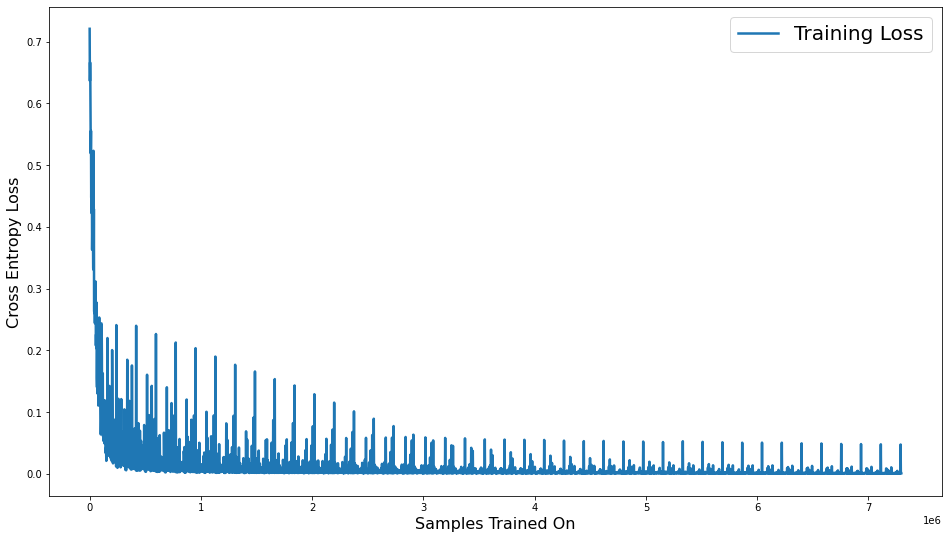

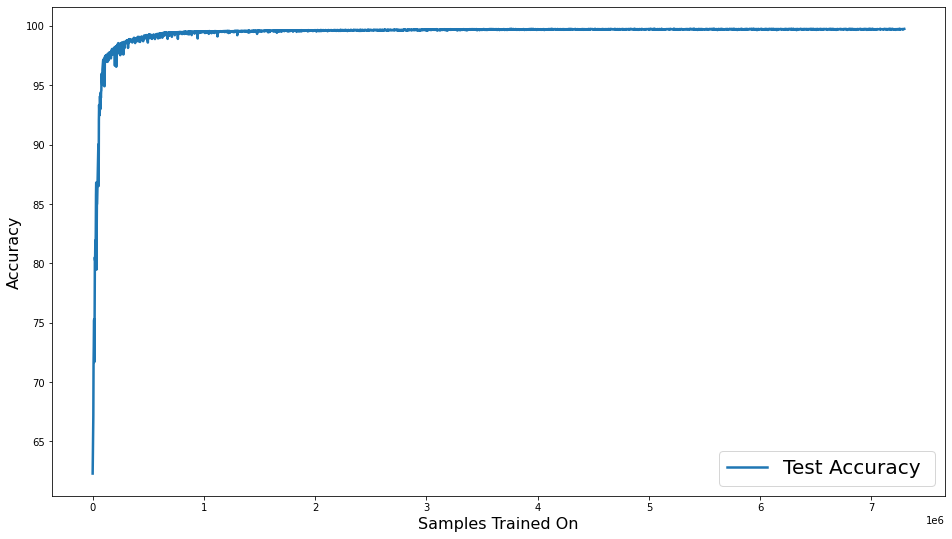

-----------------------------------------
Finished work on model: 2class_FlowL7
-----------------------------------------
-----------------------------------------
Staring work on model: 2class_SessionL7
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/2class/SessionL7/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/SessionL7/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/SessionL7/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/SessionL7/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (114926, 28, 28, 1)
mnist.train.lables.shape: (114926,)
mnist.test.images.shape: (13325, 28, 28, 1)
mnist.test.labels.shape: (13325,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(114926, 28, 28, 1)
(114926,)
### Testing Data Shapes ###
(13325, 28, 28, 1)
(13325,)

### Training Data Stats ###
Min Value = 

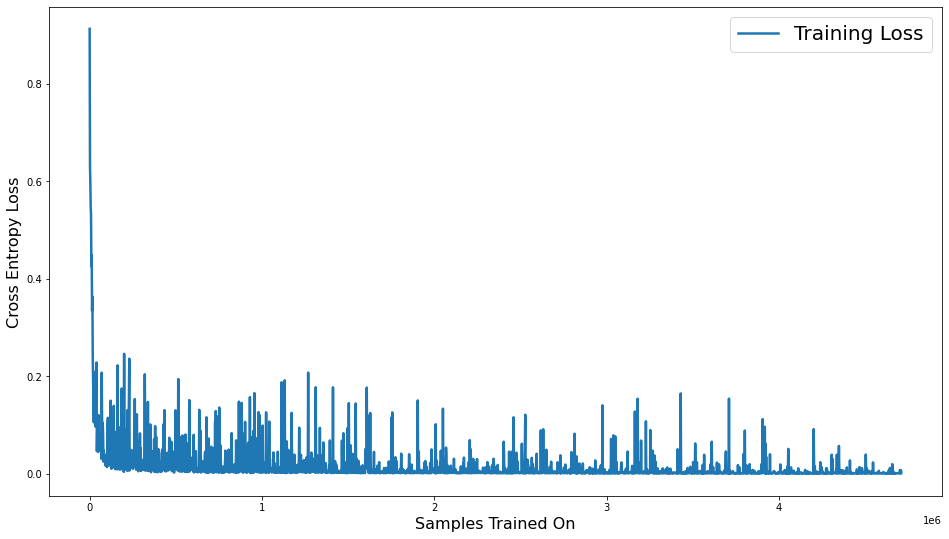

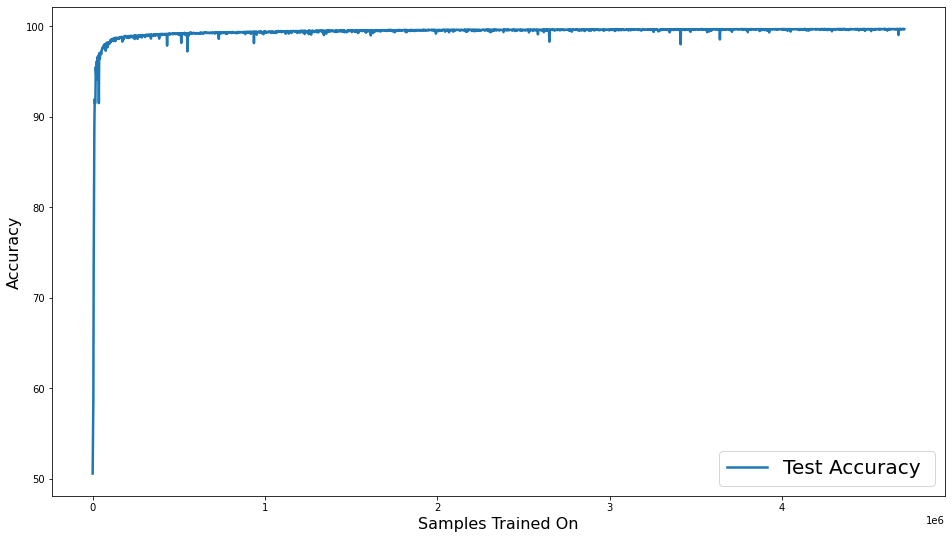

-----------------------------------------
Finished work on model: 2class_SessionL7
-----------------------------------------
-----------------------------------------
Staring work on model: 2class_FlowAllLayers
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/2class/FlowAllLayers/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/FlowAllLayers/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/FlowAllLayers/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/FlowAllLayers/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (240437, 28, 28, 1)
mnist.train.lables.shape: (240437,)
mnist.test.images.shape: (27271, 28, 28, 1)
mnist.test.labels.shape: (27271,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(240437, 28, 28, 1)
(240437,)
### Testing Data Shapes ###
(27271, 28, 28, 1)
(27271,)

### Training Data

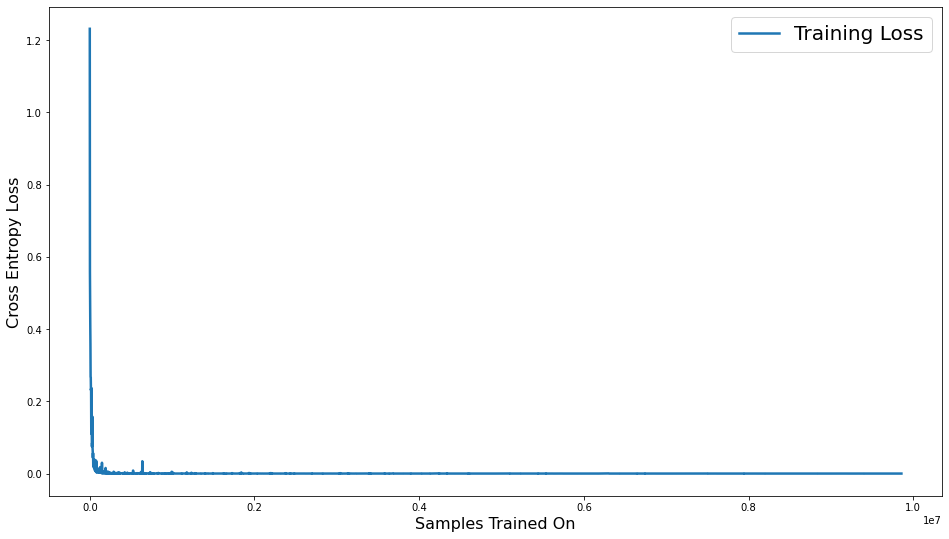

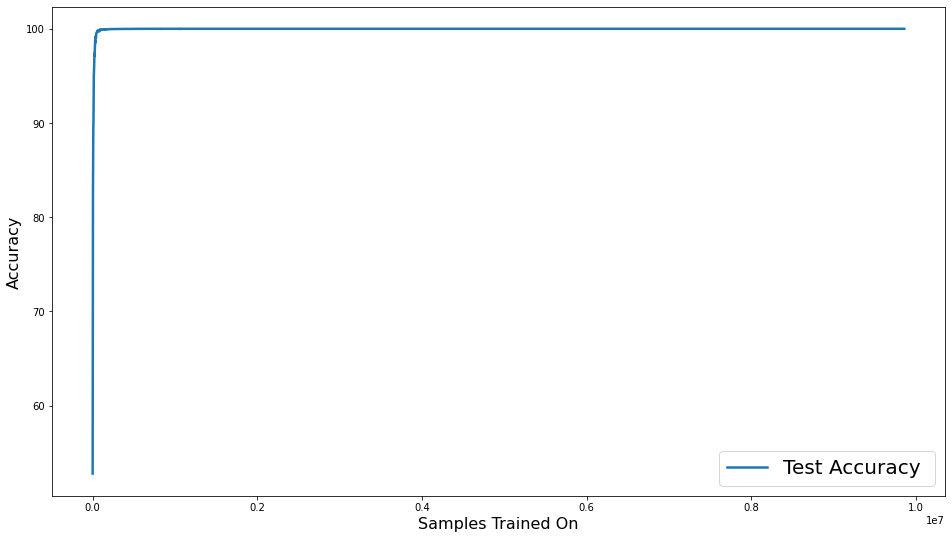

-----------------------------------------
Finished work on model: 2class_FlowAllLayers
-----------------------------------------
-----------------------------------------
Staring work on model: 2class_Session_AllLayers
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/2class/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/2class/SessionAllLayers/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (123433, 28, 28, 1)
mnist.train.lables.shape: (123433,)
mnist.test.images.shape: (14267, 28, 28, 1)
mnist.test.labels.shape: (14267,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(123433, 28, 28, 1)
(123433,)
### Testing Data Shapes ###
(14267, 28, 28, 1)
(14267,

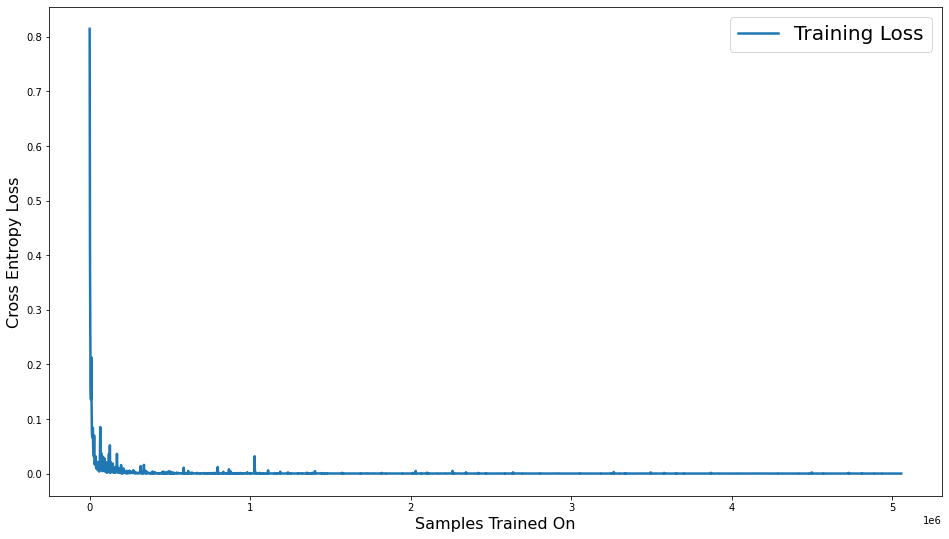

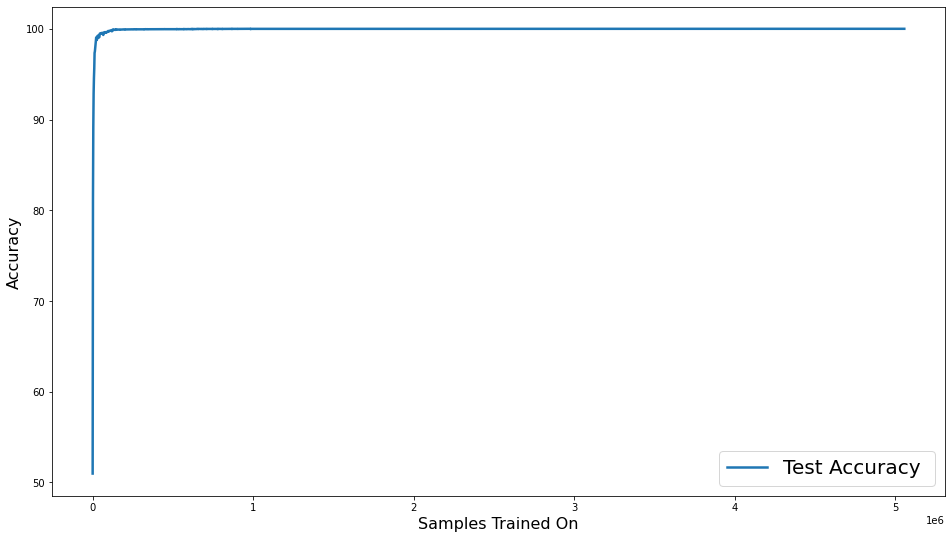

-----------------------------------------
Finished work on model: 2class_Session_AllLayers
-----------------------------------------
-----------------------------------------
Staring work on model: 20class_FlowL7
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/20class/FlowL7/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/FlowL7/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/FlowL7/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/FlowL7/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (178041, 28, 28, 1)
mnist.train.lables.shape: (178041,)
mnist.test.images.shape: (20340, 28, 28, 1)
mnist.test.labels.shape: (20340,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(178041, 28, 28, 1)
(178041,)
### Testing Data Shapes ###
(20340, 28, 28, 1)
(20340,)

### Training Data Stats ###
Min Value =

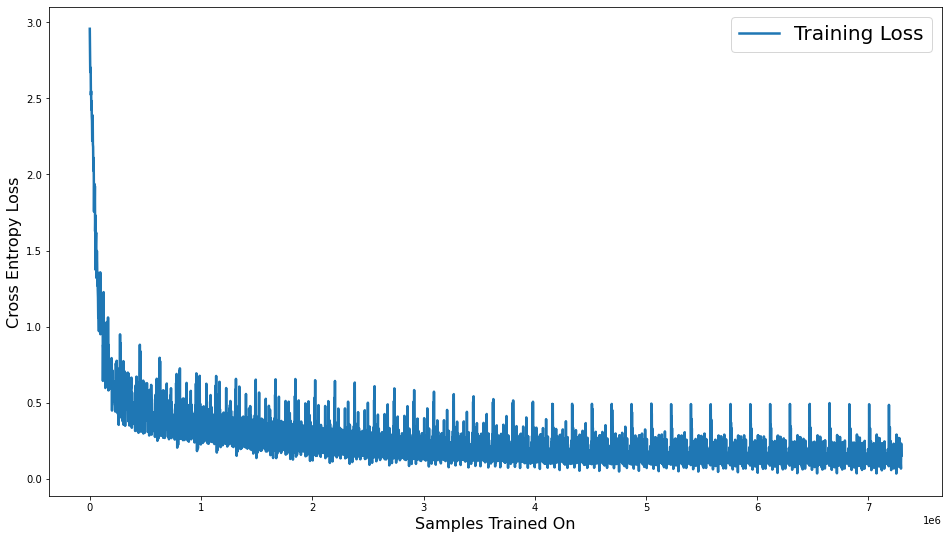

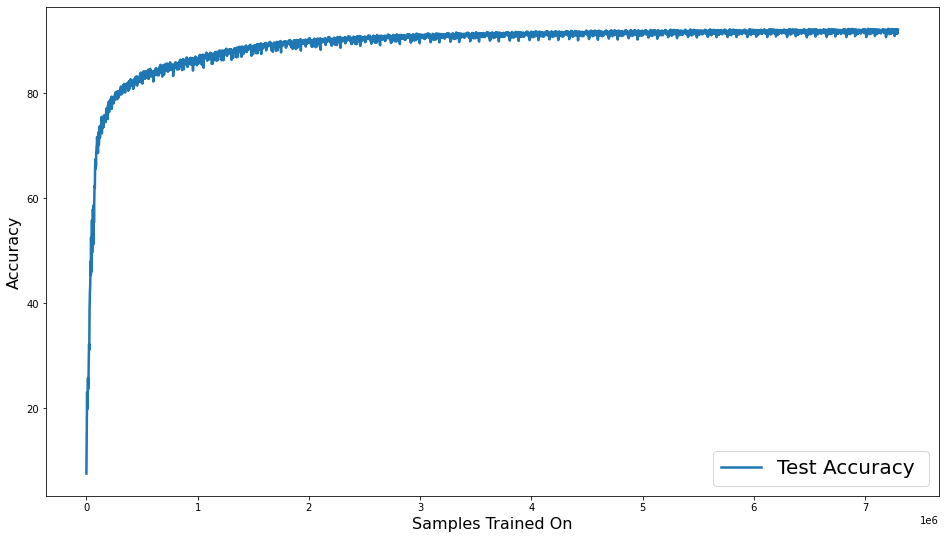

-----------------------------------------
Finished work on model: 20class_FlowL7
-----------------------------------------
-----------------------------------------
Staring work on model: 20class_SessionL7
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/20class/SessionL7/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/SessionL7/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/SessionL7/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/SessionL7/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (114926, 28, 28, 1)
mnist.train.lables.shape: (114926,)
mnist.test.images.shape: (13325, 28, 28, 1)
mnist.test.labels.shape: (13325,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(114926, 28, 28, 1)
(114926,)
### Testing Data Shapes ###
(13325, 28, 28, 1)
(13325,)

### Training Data Stats ###
Min Va

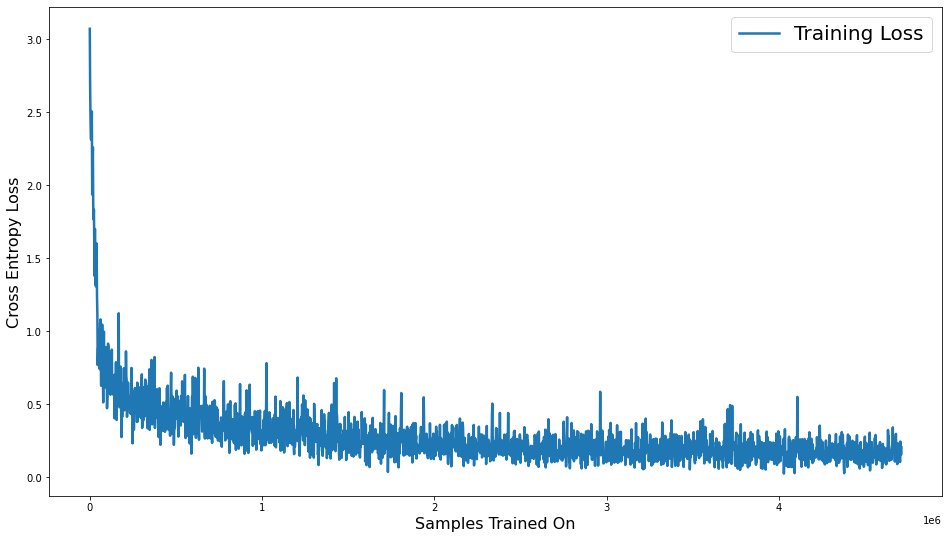

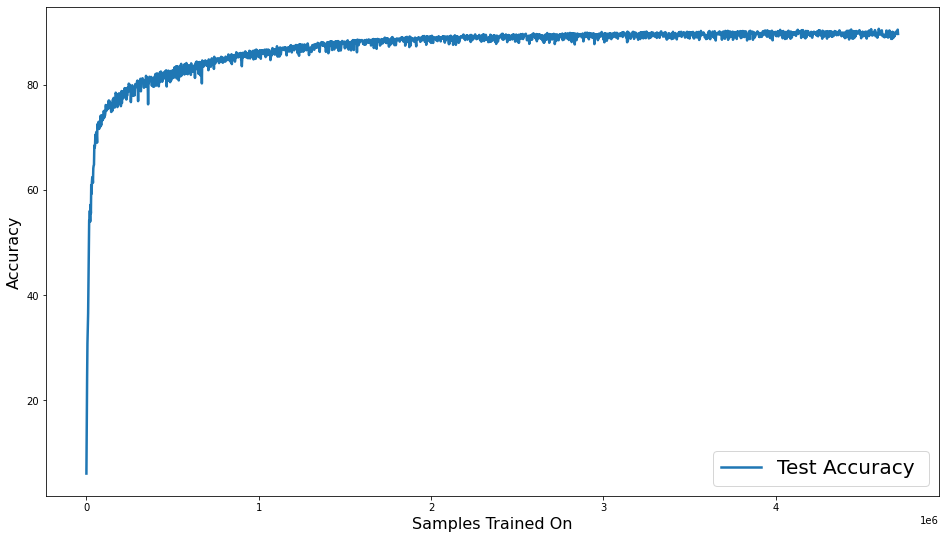

-----------------------------------------
Finished work on model: 20class_SessionL7
-----------------------------------------
-----------------------------------------
Staring work on model: 20class_FlowAllLayers
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/20class/FlowAllLayers/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/FlowAllLayers/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/FlowAllLayers/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/FlowAllLayers/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (240437, 28, 28, 1)
mnist.train.lables.shape: (240437,)
mnist.test.images.shape: (27271, 28, 28, 1)
mnist.test.labels.shape: (27271,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(240437, 28, 28, 1)
(240437,)
### Testing Data Shapes ###
(27271, 28, 28, 1)
(27271,)

### Trainin

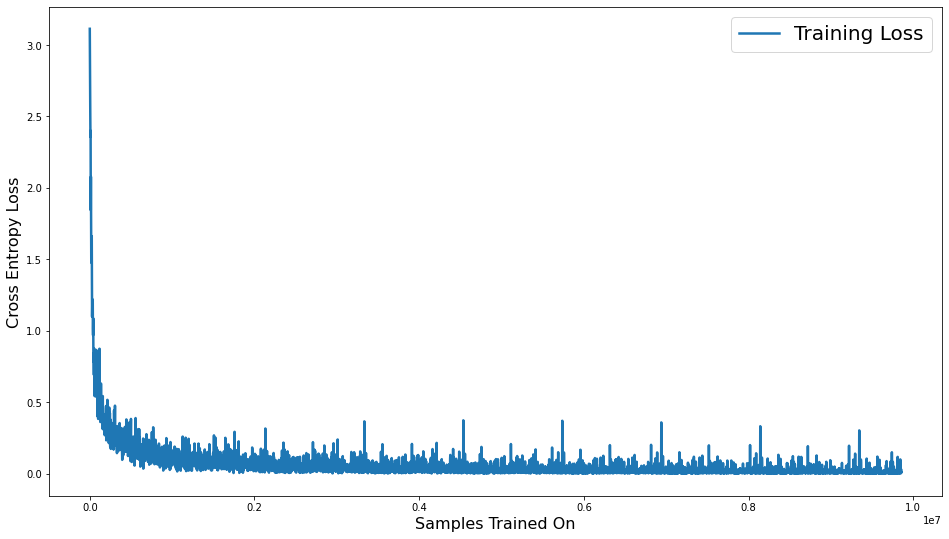

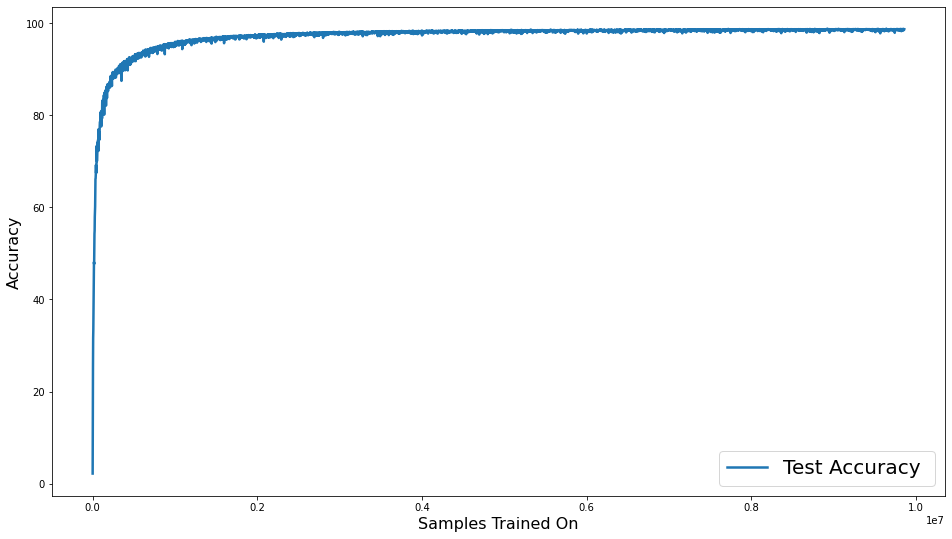

-----------------------------------------
Finished work on model: 20class_FlowAllLayers
-----------------------------------------
-----------------------------------------
Staring work on model: 20class_SessionAllLayers
-----------------------------------------
Extracting /content/drive/My Drive/cnn/data/20class/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/cnn/data/20class/SessionAllLayers/t10k-labels-idx1-ubyte.gz
mnist.train.images.shape: (123433, 28, 28, 1)
mnist.train.lables.shape: (123433,)
mnist.test.images.shape: (14267, 28, 28, 1)
mnist.test.labels.shape: (14267,)
mnist.validation.images.shape: (5000, 28, 28, 1)
mnist.validation.labels.shape: (5000,)
### Training Data Shapes ###
(123433, 28, 28, 1)
(123433,)
### Testing Data Shapes ###
(14267, 28, 28, 1)
(1

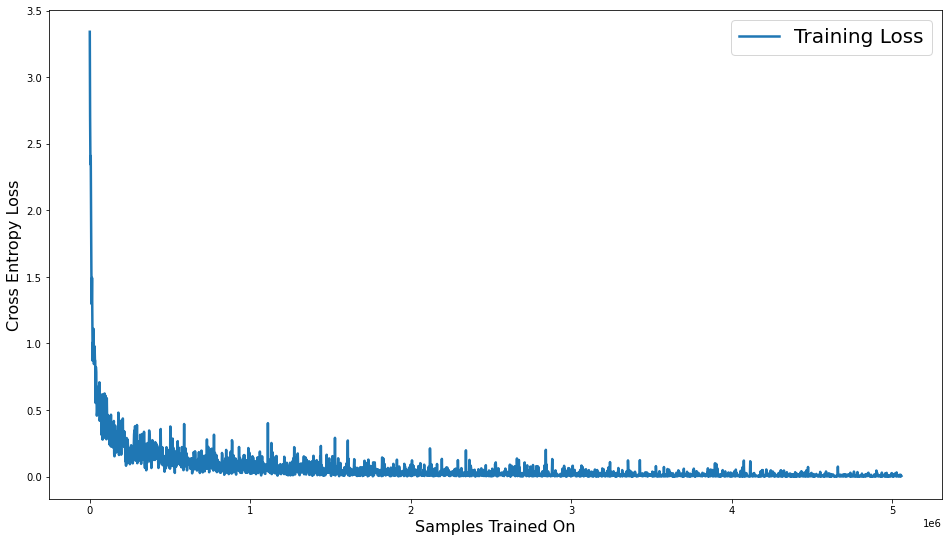

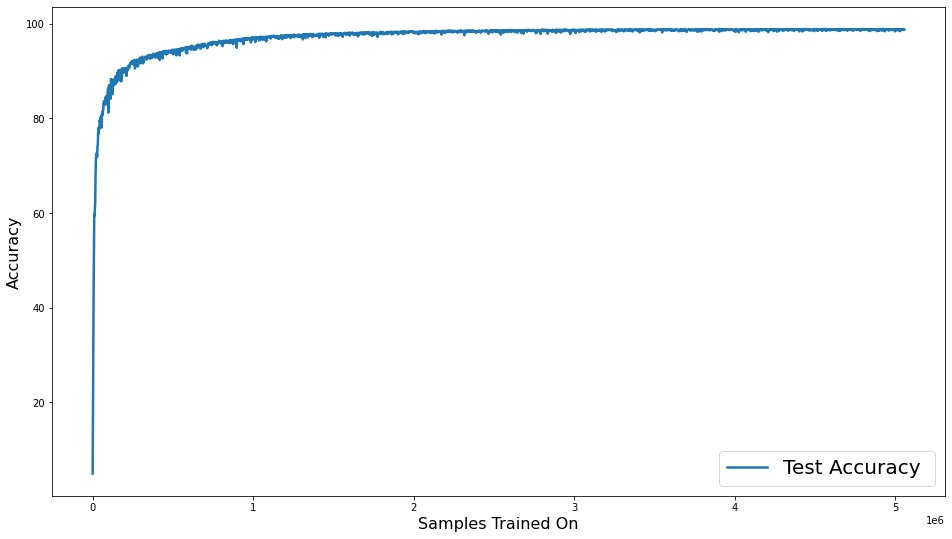

-----------------------------------------
Finished work on model: 20class_SessionAllLayers
-----------------------------------------


In [ ]:
for model_name in models.keys():
  print('-----------------------------------------')
  print(f'Staring work on model: {model_name}')
  print('-----------------------------------------')
  mnist = read_data_sets(models[model_name]["data_dir"], one_hot=False)
  # TODO they originally had one_hot=True

  print(f"mnist.train.images.shape: {mnist.train.images.shape}")
  print(f"mnist.train.lables.shape: {mnist.train.labels.shape}")
  print(f"mnist.test.images.shape: {mnist.test.images.shape}")
  print(f"mnist.test.labels.shape: {mnist.test.labels.shape}")
  print(f"mnist.validation.images.shape: {mnist.validation.images.shape}")
  print(f"mnist.validation.labels.shape: {mnist.validation.labels.shape}")

  train_X = mnist.train.images
  train_Y = mnist.train.labels
  test_X = mnist.test.images
  test_Y = mnist.test.labels
  print("### Training Data Shapes ###")
  print(train_X.shape)
  print(train_Y.shape)
  print("### Testing Data Shapes ###")
  print(test_X.shape)
  print(test_Y.shape)
  print()
  print("### Training Data Stats ###")
  print("Min Value =", np.min(train_X))
  print("Max Value =", np.max(train_X))
  print("Class Labels =", np.unique(train_Y, return_counts=True)[0])
  print("Class Frequencies =", np.unique(train_Y, return_counts=True)[1])
  print("### Testing Data Stats ###")
  print("Min Value =", np.min(test_X))
  print("Max Value =", np.max(test_X))
  print("Class Labels =", np.unique(test_Y, return_counts=True)[0])
  print("Class Frequencies =", np.unique(test_Y, return_counts=True)[1])

  #train_norm_X = np.expand_dims(train_X, axis=1)
  #test_norm_X = np.expand_dims(test_X, axis=1)
  train_norm_X = np.moveaxis(train_X, [0, 1, 2, 3], [0, 2, 3, 1])
  test_norm_X = np.moveaxis(test_X, [0, 1, 2, 3], [0, 2, 3, 1])
  print("### Training Data Reshaped ###")
  print(train_norm_X.shape)
  print("### Testing Data Reshaped ###")
  print(test_norm_X.shape)

  np.random.seed(0)
  prop = 1.0
  train_sample = np.random.choice(train_norm_X.shape[0], size=int(prop * train_norm_X.shape[0]), replace=False)
  test_sample = np.random.choice(test_norm_X.shape[0], size=int(prop * test_norm_X.shape[0]), replace=False)
  N, C_in, H_in, W_in = train_norm_X.shape
  n_classes = len(np.unique(train_Y))
  cnn_model = CNN_2D(C_in, H_in, W_in, n_classes)
  models[model_name]['model'] = cnn_model
  print(f"{model_name} No. Parameters =", cnn_model.n_params())

  cnn_model.optimize(train_norm_X[train_sample], train_Y[train_sample], 
                 test_norm_X[test_sample], test_Y[test_sample],n_epochs=40)
  
  plt.figure(figsize=(16,9))
  plt.plot([x * 2000 for x in range(len(cnn_model.mb_train_losses))], cnn_model.mb_train_losses, label="Training Loss", linewidth=2.5)
  plt.ylabel("Cross Entropy Loss", fontsize=16)
  plt.xlabel("Samples Trained On", fontsize=16)
  plt.legend(prop={"size":20})
  plt.show()

  plt.figure(figsize=(16,9))
  plt.plot([x * 2000 for x in range(len(cnn_model.mb_train_losses))],cnn_model.mb_test_accs, label="Test Accuracy ", linewidth=2.5)
  plt.ylabel("Accuracy", fontsize=16)
  plt.xlabel("Samples Trained On", fontsize=16)
  plt.legend(prop={"size":20})
  plt.show()


  print('-----------------------------------------')
  print(f'Finished work on model: {model_name}')
  print('-----------------------------------------')

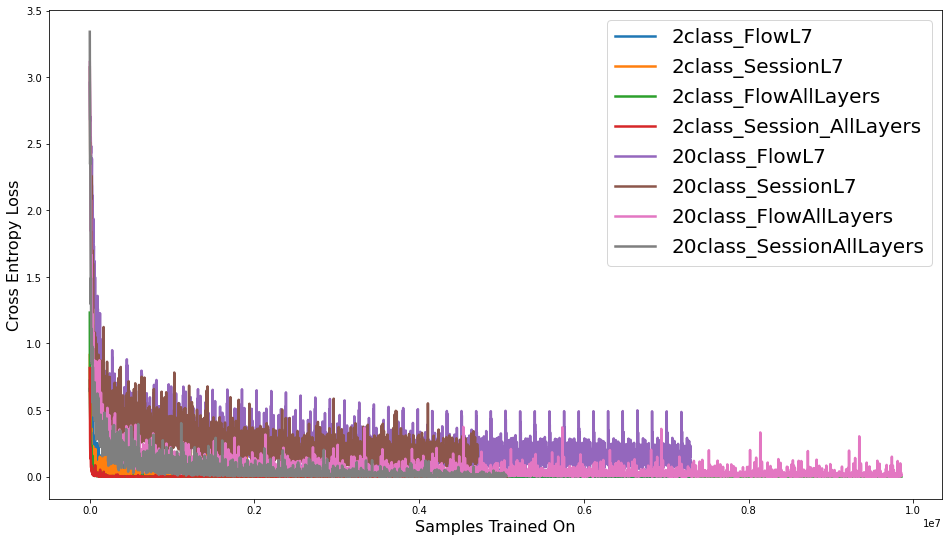

In [ ]:
plt.figure(figsize=(16,9))
for model_name in models.keys():
  model = models[model_name]['model']
  plt.plot([x * 2000 for x in range(len(model.mb_train_losses))], model.mb_train_losses, label=model_name, linewidth=2.5)
plt.ylabel("Cross Entropy Loss", fontsize=16)
plt.xlabel("Samples Trained On", fontsize=16)
plt.legend(prop={"size":20})
plt.show()

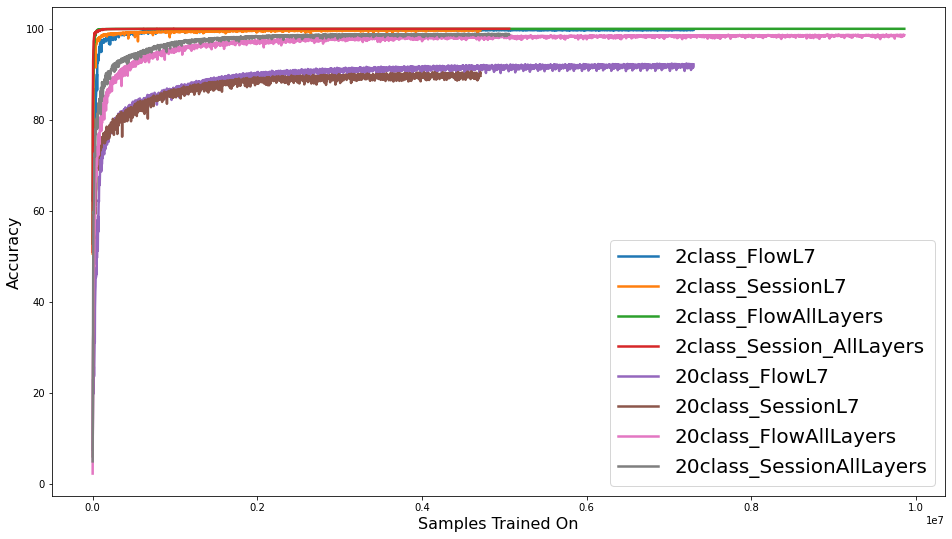

In [ ]:
plt.figure(figsize=(16,9))
for model_name in models.keys():
  model = models[model_name]['model']
  plt.plot([x * 2000 for x in range(len(model.mb_train_losses))],model.mb_test_accs, label=model_name, linewidth=2.5)
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Samples Trained On", fontsize=16)
plt.legend(prop={"size":20})
plt.show()

In [ ]:
dict_2class = {0:'Benign',1:'Malware'}
dict_20class = {0:'BitTorrent',1:'Facetime',2:'FTP',3:'Gmail',4:'MySQL',5:'Outlook',6:'Skype',7:'SMB',8:'Weibo',9:'WorldOfWarcraft',10:'Cridex',11:'Geodo',12:'Htbot',13:'Miuref',14:'Neris',15:'Nsis-ay',16:'Shifu',17:'Tinba',18:'Virut',19:'Zeus'}
accuracies = []
for model_name in models.keys():
  model = models[model_name]["model"]
  if '20' in model_name:
    models[model_name]["labels"] = dict_20class
  else:
    models[model_name]["labels"] = dict_2class
  Yhat = model.predict(model.input_test_X,tensor=True).cpu()
  acc = accuracy(model.input_test_Y,Yhat)
  accuracies.append(acc)
  print(f'Accuracy for {model_name} is {acc}')
  models[model_name]["accuracy"] = acc
  models[model_name]["precisions"] = precision_score(model.input_test_Y,Yhat,average=None)
  models[model_name]["recalls"] = recall_score(model.input_test_Y,Yhat,average=None)
  models[model_name]["f1s"] = f1_score(model.input_test_Y,Yhat,average=None)

print()
for model_name in models.keys():
  print(f"{model_name}")
  print(f'data,P,R,F1')
  for key in models[model_name]["labels"].keys():
    print(f'{models[model_name]["labels"][key]},{models[model_name]["precisions"][key]:.3f},{models[model_name]["recalls"][key]:.3f},{models[model_name]["f1s"][key]:.3f}')
  print()

Accuracy for 2class_FlowL7 is 99.72959756851196
Accuracy for 2class_SessionL7 is 99.65478181838989
Accuracy for 2class_FlowAllLayers is 100.0
Accuracy for 2class_Session_AllLayers is 100.0
Accuracy for 20class_FlowL7 is 92.17305779457092
Accuracy for 20class_SessionL7 is 89.77861404418945
Accuracy for 20class_FlowAllLayers is 98.66524934768677
Accuracy for 20class_SessionAllLayers is 98.80843758583069

2class_FlowL7
data,P,R,F1
Benign,0.995,0.998,0.996
Malware,0.999,0.997,0.998

2class_SessionL7
data,P,R,F1
Benign,0.997,0.996,0.996
Malware,0.996,0.997,0.997

2class_FlowAllLayers
data,P,R,F1
Benign,1.000,1.000,1.000
Malware,1.000,1.000,1.000

2class_Session_AllLayers
data,P,R,F1
Benign,1.000,1.000,1.000
Malware,1.000,1.000,1.000

20class_FlowL7
data,P,R,F1
BitTorrent,0.623,0.580,0.601
Facetime,1.000,1.000,1.000
FTP,0.999,0.994,0.997
Gmail,0.820,0.307,0.447
MySQL,0.999,0.998,0.998
Outlook,0.489,0.743,0.590
Skype,1.000,1.000,1.000
SMB,0.973,0.986,0.980
Weibo,0.974,0.974,0.974
WorldOfWarcr

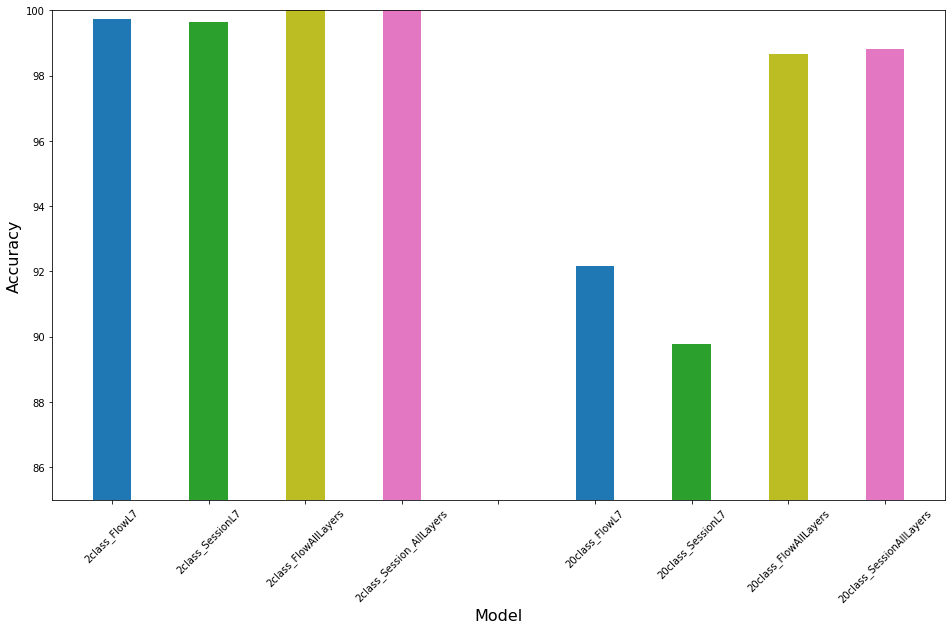

In [ ]:
plt.figure(figsize=(16,9))
x = list(models.keys())
y = accuracies
plt.bar(x[0:4]+['']+x[4:],y[0:4]+[0]+y[4:],width=0.4,color=['tab:blue','tab:green','tab:olive','tab:pink','red'])
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.ylim(85,100)
plt.xticks(rotation=45)
plt.show()

[ 2650  8728 12332  3401  3941 11972     2  8248  6806]
[0 0 0 0 0 0 0 0 0]
20class_SessionAllLayers: BitTorrent


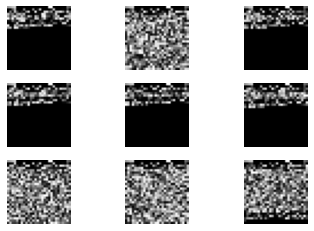

[10947  1307  1036 11583  3976  2931 10973  9892 11105]
[1 1 1 1 1 1 1 1 1]
20class_SessionAllLayers: Facetime


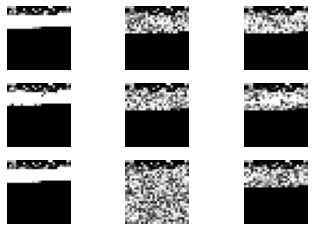

[ 6401 10391  9037  5985  6640 10781  1612 10835 13188]
[2 2 2 2 2 2 2 2 2]
20class_SessionAllLayers: FTP


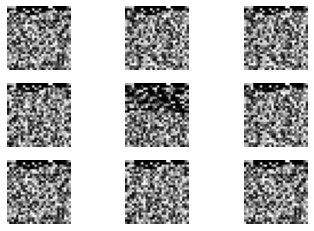

[12231  7161  7278  7129  6701  4007  7002 12262  3605]
[3 3 3 3 3 3 3 3 3]
20class_SessionAllLayers: Gmail


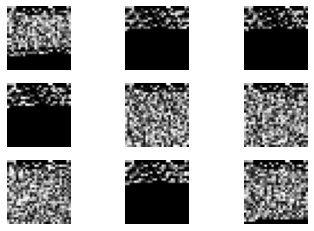

[11208  3472  2379 12315  7274  2570 11705 12038  8709]
[4 4 4 4 4 4 4 4 4]
20class_SessionAllLayers: MySQL


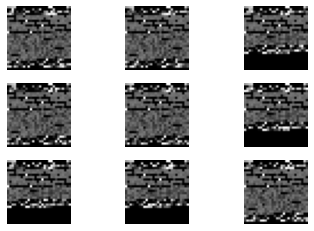

[ 6958 13588 13115  7314  9040  9303  1557  3301 14262]
[5 5 5 5 5 5 5 5 5]
20class_SessionAllLayers: Outlook


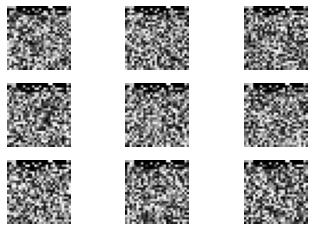

[ 6764 10893 10578  6272  4884  5541  3026   522 12793]
[6 6 6 6 6 6 6 6 6]
20class_SessionAllLayers: Skype


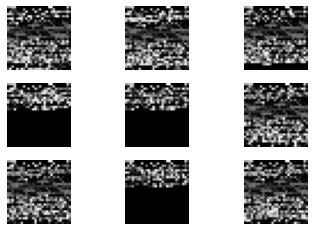

[ 1408 10555  4931  9045 10261 12707  6404  6043  5268]
[7 7 7 7 7 7 7 7 7]
20class_SessionAllLayers: SMB


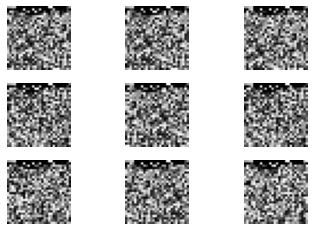

[ 8262 12641  6135 13450  9914 11861  8255  7325  7749]
[8 8 8 8 8 8 8 8 8]
20class_SessionAllLayers: Weibo


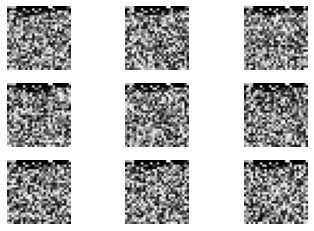

[ 6440  5819  9956  7079 11369  4115   999  6748  3712]
[9 9 9 9 9 9 9 9 9]
20class_SessionAllLayers: WorldOfWarcraft


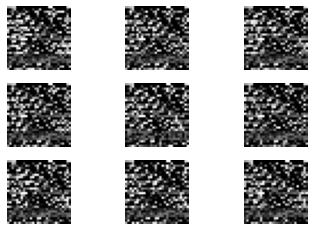

[  297  5799 13704  2012  6678 10214  4944 12946 11925]
[10 10 10 10 10 10 10 10 10]
20class_SessionAllLayers: Cridex


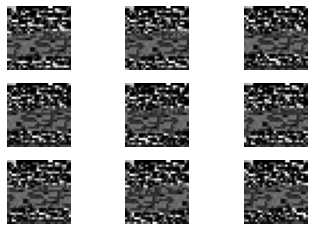

[ 7104  2857 10878 11125 11057  2245  6304  3751  1758]
[11 11 11 11 11 11 11 11 11]
20class_SessionAllLayers: Geodo


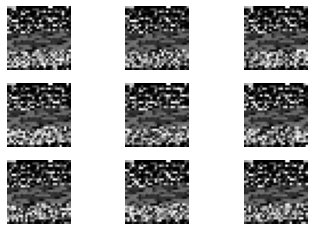

[ 2132 13110 10044  7591  1811  1894 10970  6839  2348]
[12 12 12 12 12 12 12 12 12]
20class_SessionAllLayers: Htbot


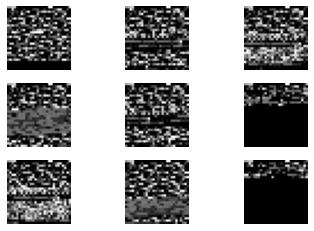

[ 8738 12137   503 11381  6978 11381  4269  1024  2102]
[13 13 13 13 13 13 13 13 13]
20class_SessionAllLayers: Miuref


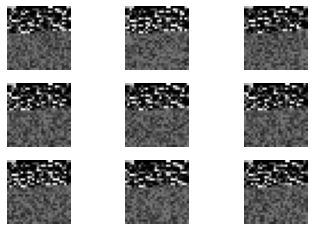

[ 4919   537   716   292 13087  8394 11797  1231  8778]
[14 14 14 14 14 14 14 14 14]
20class_SessionAllLayers: Neris


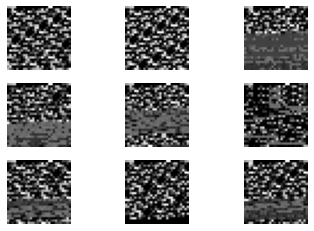

[7149 4704 9528 1306 8422  936 1121 4386  759]
[15 15 15 15 15 15 15 15 15]
20class_SessionAllLayers: Nsis-ay


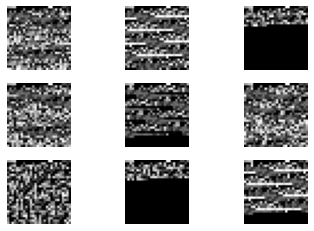

[ 1341   205  5255 11587  7964 11324  2336 11074  1412]
[16 16 16 16 16 16 16 16 16]
20class_SessionAllLayers: Shifu


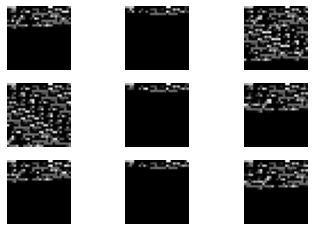

[ 6985 10394 14204 10744 10786 10204  8439 10604  1635]
[17 17 17 17 17 17 17 17 17]
20class_SessionAllLayers: Tinba


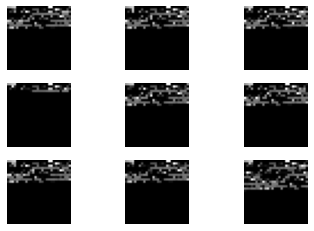

[13088  3592 10192  5483 11980  5424  9756  8505  8026]
[18 18 18 18 18 18 18 18 18]
20class_SessionAllLayers: Virut


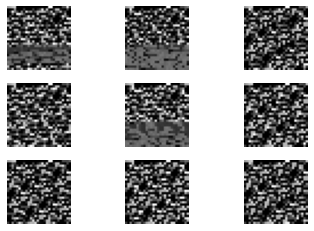

[13161 13172  3608  4220  7108  5556 10052  1947  6611]
[19 19 19 19 19 19 19 19 19]
20class_SessionAllLayers: Zeus


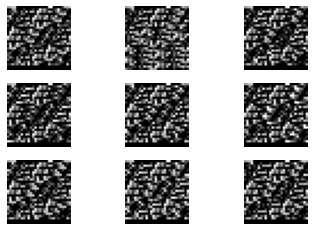

In [ ]:
for model_name in models.keys():
  if '20class_SessionAllLayers' in model_name:
    model = models[model_name]["model"]
    for key in models[model_name]["labels"].keys():
      test_Y = model.input_test_Y.numpy()
      test_X = model.input_test_X.numpy()
      idx = np.array(np.where(test_Y == key))
      idx = idx.reshape((idx.shape[1]))
      rand_idx = np.random.choice(idx,size=9)
      print(rand_idx)
      print(test_Y[rand_idx])
      #rand_idx = [1,2,3,4,5,6,7,8,9]
      print(f'{model_name}: {models[model_name]["labels"][key]}')
      fig, axs = plt.subplots(3, 3)
      i=0
      for row in range(3):
        for col in range(3):
          axs[row,col].imshow(test_X[rand_idx[i]].reshape(28,28), cmap="gray")
          axs[row,col].axis('off') 
          i += 1   
      plt.show()
    break  
